In [1]:
from danial import f3, pre_fcs, fcs, vgg, spg, prm, dataloader
import torch

In [2]:
test = dataloader.load_image("assets/camo-sold-d.png", target_size = (224,224))

In [10]:
VGG = vgg.backbone()


spg_module = spg.SPGWithFPN(in_channels1=64, in_channels2=256)

f3_module = f3.F3Conv(in_channels=256, out_channels=128)

prm_module = prm.PRM(f3_channels=128, spg_channels=256, fused_channels=128)

pre_crfcs = pre_fcs.PreFCS()

crfcs = fcs.CRFCS(roi_channels=64, boundary_channels=64)


In [4]:
features = VGG(test, return_all=True)
for items in features:
    print(features[items].shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 7, 7])


In [5]:
spg_out = spg_module(features['block1'], features['block3'])
print("SPG output shape:", spg_out.shape)

SPG output shape: torch.Size([1, 256, 112, 112])


In [6]:
f3_out = f3_module(features['block3'])

print(f3_out.shape)


torch.Size([1, 128, 28, 28])


In [7]:
prm_out = prm_module(f3_out, spg_out)
print(prm_out.shape)

torch.Size([1, 1, 64, 56, 56])


In [8]:
ROI = pre_crfcs(f3_out,prm_out)
branch = pre_crfcs.branch
print(ROI.shape)
print(branch.shape)

torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 56, 56])


tensor([[ 0.0038,  0.0389,  0.0240, -0.0920, -0.0644]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0543, -0.0285,  0.1046,  0.0500]], grad_fn=<AddmmBackward0>)


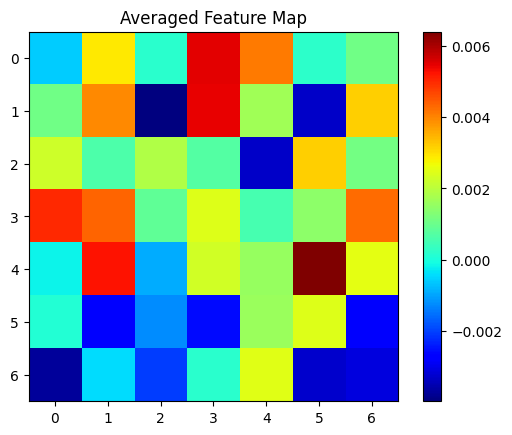

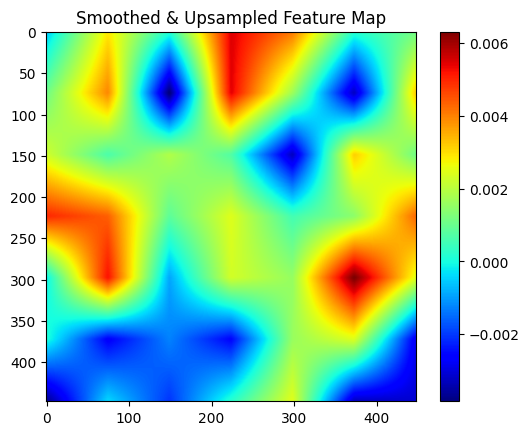

In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

cls_out, reg_out, recovered = crfcs(ROI, branch)
print(cls_out)
print(reg_out)


avg_map = recovered.mean(dim=1)  # [1, 7, 7]

plt.imshow(avg_map[0].detach().cpu(), cmap='jet')
plt.title("Averaged Feature Map")
plt.colorbar()
plt.show()

avg_map = recovered.mean(dim=1, keepdim=True)  # [1, 1, 7, 7]

# 1️⃣ Upsample to higher resolution (e.g., 224x224)
upsampled = F.interpolate(avg_map, size=(448,448), mode='bilinear', align_corners=True)

# 2️⃣ Apply Gaussian blur
blur = GaussianBlur(kernel_size=(7,7), sigma=(1.0,1.0))
smoothed = blur(upsampled)

# 3️⃣ Show result
plt.imshow(smoothed[0, 0].detach().cpu(), cmap='jet')  # using 'jet' for heatmap look
plt.title("Smoothed & Upsampled Feature Map")
plt.colorbar()
plt.show()
